In [1]:
import mat4py
import pandas as pd
import numpy as np
import scipy
import scipy.io as sio
import math
import warnings
import warnings
import time
from itertools import combinations
from itertools import product

from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [2]:
data = mat4py.loadmat('C:/Users/liang/Documents/GitHub/ChoiceInteraction/PRL_all_-500_500_250_1500_spkcounts_norm0.mat')
PRL = pd.DataFrame.from_dict(data['Data'])
Var = data['Var']
varName = { i : Var[i] for i in range(len(Var)) }
PRL.rename(columns=varName,inplace=True)
PRL.dropna(inplace=True)
ts = PRL.shape[1] - len(Var)
PRL_regressors = ['Loc','PreLoc','RL','PRL','LocInter','Col','PreCol','RC','PRC','ColInter',
    'Rwd','PreRwd','POS','ChosenMag','UnchosenMag','LMag','HVL','SwitchHVL']

data = mat4py.loadmat('C:/Users/liang/Documents/GitHub/ChoiceInteraction/MP_all_-500_500_250_1500_spkcounts_norm0.mat')
MP = pd.DataFrame.from_dict(data['Data'])
Var = data['Var']
varName = { i : Var[i] for i in range(len(Var)) }
MP.rename(columns=varName,inplace=True)
MP.dropna(inplace=True)
MP_regressors = ['Loc','PreLoc','RL','PRL','LocInter','Rwd','PreRwd']

In [29]:
def calculate_coef(data, regressors, timestamps, method='Gauss'):

    cell_num = data.cellid.unique().size   
    coef = np.zeros((cell_num,len(regressors)+1,len(timestamps)))
    residual = np.zeros((cell_num,len(timestamps)))
    
    if method == 'Poisson':
        clf = linear_model.PoissonRegressor()
    else:
        clf = linear_model.LinearRegression()

    for c in range(1,cell_num+1):

        cData = data[(data['cellid']==c)] 
        F = cData.loc[:,regressors].to_numpy()
        
        for time_ind, t in enumerate(timestamps):
        
            FR = cData[cData.columns[-ts:]].to_numpy()[:,t]

            if method == 'Poisson':

                clf.fit(F, FR)
                coef[c-1,:,time_ind] = np.append(clf.intercept_,clf.coef_)

            if method == 'Gauss':

                FR_sorted = np.sort(FR)
                ind = np.argsort(FR)
                FR_g = np.random.normal(size=len(FR_sorted))
                FR_g_sorted = np.sort(FR_g)
                FR_t = np.zeros(len(FR_sorted))
                FR_t[ind] = FR_g_sorted

                clf.fit(F, FR_t)
                coef[c-1,:,time_ind] = np.append(clf.intercept_,clf.coef_)
                residual[c-1,time_ind] = np.var(FR_t-np.dot(F,coef[c-1,1:,time_ind])-coef[c-1,0,time_ind])
                
    original = {'coef': coef, 
                'res': residual} 
                
    return original

In [81]:
def coef_manipulation(original_coef, regressors, var, coefmode, cov, timestamps): 
    
    cell_num = original_coef.shape[0] 
    timestamps = original_coef.shape[2] 
    mani_coef = original_coef.copy()
    varOI = [var,'Pre'+var,var+'Inter']
    var1_ind = np.where([x==var for x in regressors])[0][0]+1
    var2_ind = np.where([x==var+'Inter' for x in regressors])[0][0]+1
    
    if coefmode == 'Reorder':
                    
        a = np.random.multivariate_normal([0,0],[[1,cov],[cov,1]],size=cell_num)
        a_sorted = np.zeros((cell_num,2))
        var2_reordered = np.zeros(cell_num)

        for time_ind in range(timestamps):
            
            var1_coef = original_coef[:,var1_ind,time_ind]
            var2_coef = original_coef[:,var2_ind,time_ind]

            ind = np.argsort(var1_coef)  
            a_sorted[ind,:] = a[a[:,0].argsort()]

            var2_cellind = np.argsort(a_sorted[:,1])
            var2_sorted = np.sort(var2_coef) 

            mani_coef[var2_cellind,var2_ind,time_ind] = var2_sorted
                
    if coefmode == 'Removal':
        mani_coef[:,var2_ind,:] = 0
            
    return mani_coef

In [30]:
def generate_data(data, regressors, var, original, mani_coef, timestamps, method='Gauss'):
    
    cell_num = data.cellid.unique().size 
    surrogateData = data.copy()
    Y = np.array([])
    varOI = [var,'Pre'+var,var+'Inter']
    refit_coef = np.zeros(mani_coef.shape)
        
    if method == 'Poisson':
        clf = linear_model.PoissonRegressor()
    else:
        clf = linear_model.LinearRegression()  
        
    for c in range(1,cell_num+1):

        cData = data[(data['cellid']==c)] 
        F = cData.loc[:,regressors].to_numpy()
        y = np.zeros((len(F),len(timestamps)))
        
        for time_ind, t in enumerate(timestamps):
        
            FR = cData[cData.columns[-ts:]].to_numpy()[:,t]

            if method == 'Poisson':

                lamda = np.exp(mani_coef[c-1,0,time_ind]+np.dot(F,mani_coef[c-1,1:,time_ind]))
                for i in range(len(FR)):
                    y[i,time_ind] = scipy.stats.poisson.rvs(lamda[i])
                

            if method == 'Gauss':

                y_gaussian = mani_coef[c-1,0,time_ind] + np.dot(F,mani_coef[c-1,1:,time_ind]) + np.random.normal(0, np.sqrt(original['res'][c-1,time_ind]), len(FR))
                FR_sorted = np.sort(FR)      # sort the original spike counts
                ind = np.argsort(y_gaussian)  # map 
                y[ind,time_ind] = FR_sorted

            clf.fit(F, y[:,time_ind])
            refit_coef[c-1,:,time_ind] = np.append(clf.intercept_,clf.coef_)
        
        if len(Y) == 0:
            Y = y
        else:
            Y = np.append(Y,y,axis=0)
            
    surrogateData.iloc[:,-ts+np.array(timestamps)] = Y
        
    return surrogateData, refit_coef

In [11]:
def create_dataset(data, var1, var2, var3='PreRwd', train_trialNum=100, test_trialNum=50):

    cell_num = data.cellid.unique()
    k = 3
    train = [[] for x in range(k)]
    test = [[] for x in range(k)]

    for val1 in np.unique(data[var1]):  
        for val2 in np.unique(data[var2]):
            for val3 in np.unique(data[var3]):

                temp = data[(data[var1]==val1) & (data[var2]==val2) & (data[var3]==val3)]
                train_temp = [np.zeros([train_trialNum,ts,cell_num.size]) for x in range(k)]
                test_temp = [np.zeros([test_trialNum,ts,cell_num.size]) for x in range(k)]

                for c in range(cell_num.size):
                    
                    cData = temp[temp.cellid==cell_num[c]]

                    trialNum = np.array(cData.index)
                    kf = KFold(n_splits=k, shuffle=True)

                    if len(trialNum)<3:

                        for i in range(k):
                            train_temp[i][:,:,c] = np.nan
                            test_temp[i][:,:,c] = np.nan

                    else:

                        for i, (c_train_ind, c_test_ind) in enumerate(kf.split(trialNum)):

                            c_train = cData.iloc[c_train_ind]
                            c_test = cData.iloc[c_test_ind]        
                            c_train_rsm = np.random.randint(c_train.shape[0],size=train_trialNum)
                            c_test_rsm = np.random.randint(c_test.shape[0],size=test_trialNum)
                            c_train_data = c_train.iloc[c_train_rsm]
                            c_test_data = c_test.iloc[c_test_rsm]

                            train_temp[i][:,:,c] = c_train_data[c_train_data.columns[-ts:]].to_numpy()
                            test_temp[i][:,:,c] = c_test_data[c_test_data.columns[-ts:]].to_numpy()

                for i in range(k):

                    train_temp[i]  = np.concatenate((train_temp[i],np.tile([val1,val2,val1*val2],(train_trialNum,ts,1))), axis=2)
                    test_temp[i]  = np.concatenate((test_temp[i],np.tile([val1,val2,val1*val2],(test_trialNum,ts,1))), axis=2)                    

                    if len(train[i]) == 0:
                        train[i] = train_temp[i]
                        test[i] = test_temp[i]
                    else:
                        train[i] = np.append(train[i],train_temp[i],axis=0) 
                        test[i] = np.append(test[i],test_temp[i],axis=0) 


    return train, test


In [227]:
def decode(data, var, timestamps, num_iter=10, train_trialNum=100, test_trialNum=50):
    
    Accuracy = np.zeros((num_iter,3,len(timestamps),5))
    Projection = np.zeros((num_iter,3,len(timestamps),test_trialNum*8,7))
    
    clf1 = SVC(kernel='linear')
    clf2 = SVC(kernel='linear')
    clf3 = SVC(kernel='linear')
    clf4 = SVC(kernel='linear',probability=True) 
        
    for n in range(num_iter):

        train,test = create_dataset(data,var,'Pre'+var, train_trialNum=100, test_trialNum=50)

        for k in range(3):

            cellindex = (~np.isnan(train[k][:,0,:-3].mean(axis=0))) & (~np.isnan(test[k][:,0,:-3].mean(axis=0)))  
            
            for i, t in enumerate(timestamps):

                clf1.fit(train[k][:,t,:-3][:,cellindex],train[k][:,t,-3])
                clf2.fit(train[k][:,t,:-3][:,cellindex],train[k][:,t,-2])
                clf3.fit(train[k][:,t,:-3][:,cellindex],train[k][:,t,-1])
                clf4.fit(train[k][:,t,:-3][:,cellindex],train[k][:,t,-3]*2+train[k][:,t,-2])

                Accuracy[n,k,i,0] = accuracy_score(clf1.predict(test[k][:,t,:-3]),test[k][:,t,-3])
                Accuracy[n,k,i,1] = accuracy_score(clf2.predict(test[k][:,t,:-3]),test[k][:,t,-2])
                Accuracy[n,k,i,2] = accuracy_score(clf3.predict(test[k][:,t,:-3]),test[k][:,t,-1])
                Accuracy[n,k,i,3] = accuracy_score(clf4.predict(test[k][:,t,:-3]),test[k][:,t,-3]*2+test[k][:,t,-2])
                Accuracy[n,k,i,4] = t
                
                Projection[n,k,i,:,0] = test[k][:,t,-3]
                Projection[n,k,i,:,1] = test[k][:,t,-2]
                Projection[n,k,i,:,2] = test[k][:,t,-1]
                Projection[n,k,i,:,3] = np.ravel((np.dot(test[k][:,t,:-3][:,cellindex],np.transpose(clf1.coef_))+clf1.intercept_)/LA.norm(clf1.coef_))
                Projection[n,k,i,:,4] = np.ravel((np.dot(test[k][:,t,:-3][:,cellindex],np.transpose(clf2.coef_))+clf2.intercept_)/LA.norm(clf2.coef_))
                Projection[n,k,i,:,5] = np.ravel((np.dot(test[k][:,t,:-3][:,cellindex],np.transpose(clf3.coef_))+clf3.intercept_)/LA.norm(clf3.coef_))
                Projection[n,k,i,:,6] = t
                
                
    Accuracy_df = pd.DataFrame(data=Accuracy.reshape(-1,5),columns=['Current','Previous','Switch','Choice Sequence','Time'])
    Projection_df = pd.DataFrame(data=Projection.reshape(-1,7),columns=['Current','Previous','Switch','CurrentProjection',
                                                                        'PreviousProjection','SwitchProjection','Time'])
        
    return Accuracy_df, Projection_df

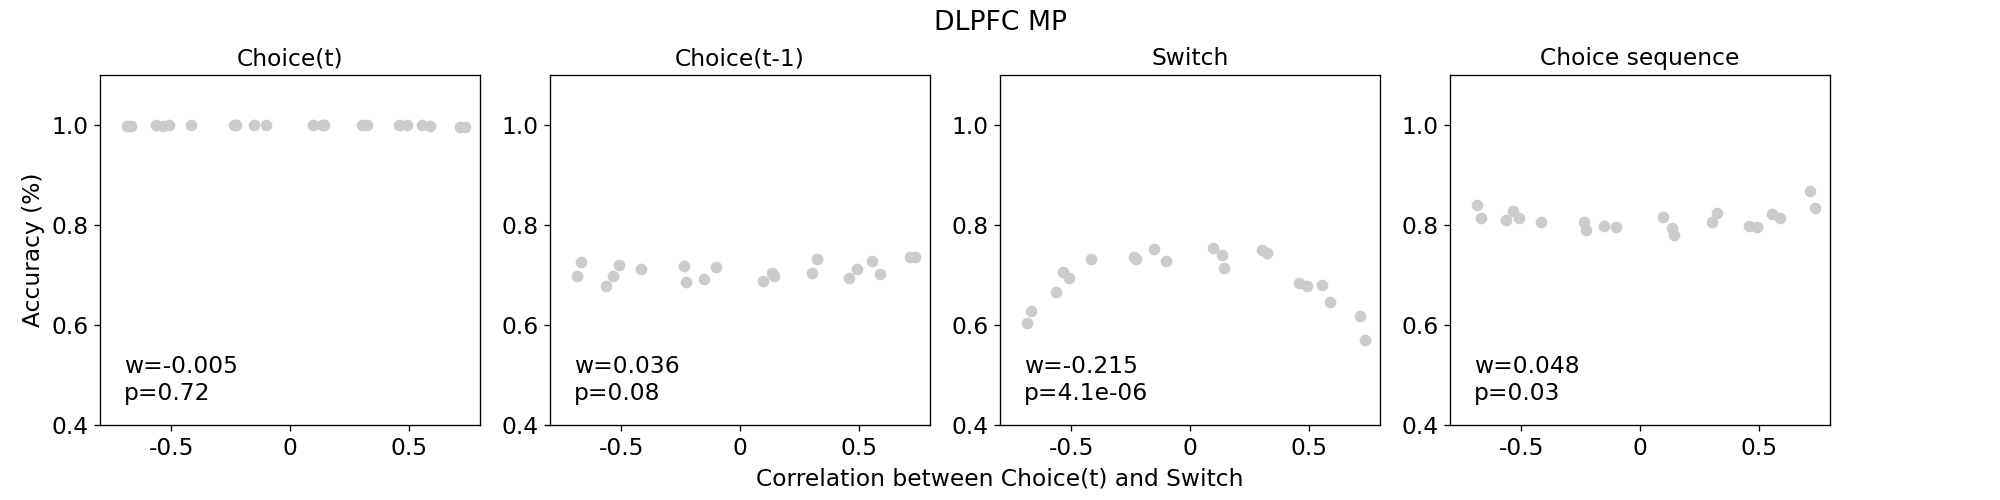

In [501]:
# data = np.load('Simulation_MP.npz')
# accuracy, corrcoef, Allcoef = data['arr_0'], data['arr_1'], data['arr_2']
plot_reorder(corrcoef,accuracy,Allcoef,'Loc',MP_regressors,'DLPFC MP','DLPFC MP simulation')

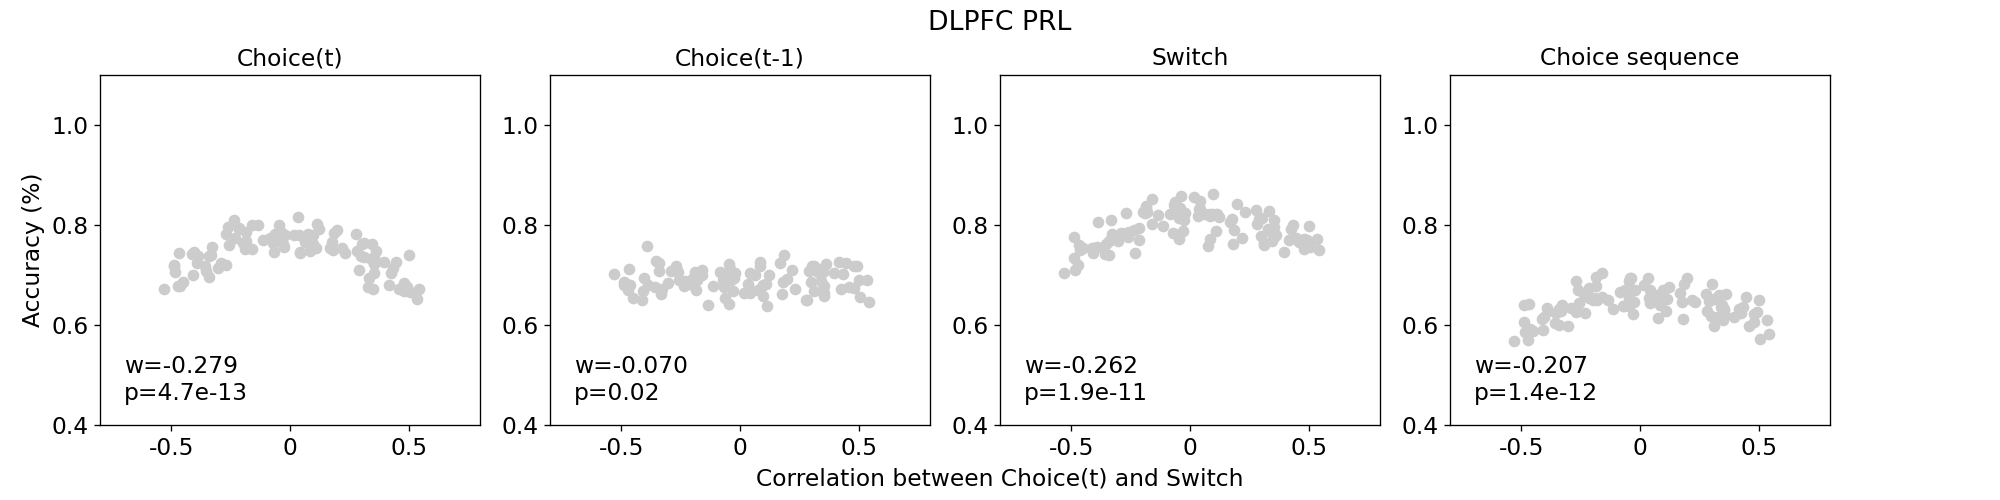

In [502]:
data = np.load('Simulation.npz')
accuracy, corrcoef, Allcoef = data['arr_0'], data['arr_1'], data['arr_2']
plot_reorder(corrcoef,accuracy,Allcoef,'Col',PRL_regressors,'DLPFC PRL','DLPFC PRL simulation')

In [500]:
def plot_reorder(corrcoef,accuracy,Allcoef,var,regressors,title,filename):
    
    
    varOI = [var,'Pre'+var,var+'Inter']
    var_ind = np.zeros(3)
    for ii in range(3):
        var_ind[ii] = np.where([x==varOI[ii] for x in regressors])[0][0]+1
    var_coef = Allcoef[:,:,var_ind.astype(int)]
    coef_norm = np.linalg.norm(var_coef, axis=1)
    regmat = np.concatenate([corrcoef,coef_norm],axis=1)
    
    plt.close('all')
    my_dpi = 120
    fig = plt.figure(figsize=(2000/my_dpi, 500/my_dpi), dpi=my_dpi,facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(1,4)
    titles=['Choice(t)','Choice(t-1)','Switch','Choice sequence']

    for c in range(4):
        
        ax = plt.subplot(gs[c])   
        mdl=sm.OLS(accuracy[:-3,c],np.abs(regmat[:-3]))
        res = mdl.fit()
#         x=[0,1]
#         y=res.predict(sm.add_constant(x))
#         plt.plot(x,y,color='k',linewidth=1,zorder=1)  
#         x=[-1,0]
#         ax.plot(x,np.flip(y),color='k',linewidth=1,zorder=1)   
        
        ax.scatter(corrcoef[:-3],accuracy[:-3,c],color=[0.8,0.8,0.8])

        if res.pvalues[0]<0.01:
            ax.text(-0.7,0.45,'w='+f"{res.params[0]:.3f}"+'\np='+f"{res.pvalues[0]:.1e}",fontsize=14)
        else:
            ax.text(-0.7,0.45,'w='+f"{res.params[0]:.3f}"+'\np='+f"{res.pvalues[0]:.2f}",fontsize=14)
        ax.set_ylim(0.4,1.1)
        ax.set_xlim(-0.8,0.8)

        if c==0:
            ax.set_ylabel('Accuracy (%)', fontsize=14)

        ax.set_title(titles[c],fontsize=14)
        ax.set_position([c*0.9/4+0.05,0.15,0.19,0.7])
        ax.set_xticks([-0.5,0,0.5])
        ax.set_xticklabels([-0.5,0,0.5], fontsize=14)
        ax.set_yticks(np.linspace(0.4,1,4))
        ax.set_yticklabels(np.linspace(0.4,1,4), fontsize=14)
        
    fig.text(0.5, 0.03, 'Correlation between Choice(t) and Switch', ha='center', fontsize=14)
    
    plt.suptitle(title,fontsize=16)
#     plt.savefig(filename)

In [490]:
def plotcoef_acc(Allcoef,accuracy,var,regressors,title='MP simulation coef ~ corr',
             filename='MP simulation coef ~ corr'):
        
    varOI = [var,'Pre'+var,var+'Inter']
    var_ind = np.zeros(3)
    for ii in range(3):
        var_ind[ii] = np.where([x==varOI[ii] for x in regressors])[0][0]+1
    var_coef = Allcoef[:,:,var_ind.astype(int)]
    coef_norm = np.linalg.norm(var_coef, axis=1)

    
#     plt.close('all')
#     fig = plt.figure(figsize=(2000/my_dpi, 500/my_dpi), dpi=my_dpi,facecolor=(1, 1, 1))
#     gs = gridspec.GridSpec(1,3)
#     titles=['Choice(t)','Choice(t-1)','Switch']

    for c in range(3):
        
        ax = plt.subplot(gs[c])   
        ax.scatter(coef_norm[:-3,c],accuracy[:-3,c],color=[0.8,0.8,0.8])

        mdl=sm.OLS(accuracy[:-3,c],sm.add_constant(coef_norm[:-3,c]))
        res = mdl.fit()
        print(res.summary())
#         x=[0,1]
#         y=res.predict(sm.add_constant(x))
#         plt.plot(x,y,color='k',linewidth=1)  
#         x=[-1,0]
#         ax.plot(x,np.flip(y),color='k',linewidth=1)    
#         ax.text(0.2,0.6,'R='+str(np.round(res.rsquared,3)))
#         ax.set_ylim(0,10)
#         ax.set_xlim(-0.8,0.8)
#         if c==0:
#             ax.set_ylabel('Population vector norm')

#         ax.set_title(titles[c])
        

#     fig.text(0.5, 0,
#              'Correlation between Choice(t) and Switch', ha='center')
    
# #     plt.suptitle(title)
#     plt.savefig(filename)

In [14]:
def plotcoef_acc(Allcoef,accuracy,title='MP simulation coef ~ acc',
             filename='MP simulation coef ~ acc'):
    
    coef_norm = np.zeros((len(accuracy),3))
    varOI = [var,'Pre'+var,var+'Inter']
    var1_ind = np.where([x==var for x in regressors])[0][0]+1
    for ii in range(len(accuracy)):
        for jj in range(3):
            coef_norm[ii,jj] = np.linalg.norm(Allcoef[ii,:,var_ind[jj]])
    
    plt.close('all')
    fig = plt.figure(figsize=(12,4),facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(1,3)
    titles=['Choice(t)','Choice(t-1)','Switch']
        
    for c in range(3):
        
        ax = plt.subplot(gs[c])   

        ax.scatter(coef_norm[:-3,c],accuracy[:-3,c],color=[0.8,0.8,0.8],label='Reorder')
        ax.scatter(coef_norm[-3,c],accuracy[-3,c],color='darkviolet',label='Removal')
        ax.scatter(coef_norm[-2,c],accuracy[-2,c],color='forestgreen',label='Original')
#         ax.scatter(coef_norm[-1,c],accuracy[-1,c],color='k',label='Data')
        mdl=sm.OLS(accuracy[:-3,c],sm.add_constant(coef_norm[:-3,c]))
        res = mdl.fit()
        x=[np.min(coef_norm[:-3,c]),np.max(coef_norm[:-3,c])]
        y=res.predict(sm.add_constant(x))
        plt.plot(x,y,color='k',linewidth=1)   
        ax.text(0.2,0.6,'R='+str(np.round(res.rsquared,3)))
        ax.set_ylim(0.4,1)
        ax.set_xlim(0,25)
        if c==0:
            ax.set_ylabel('Accuracy (%)')

        ax.set_title(titles[c])
        

    fig.text(0.5, 0,
             'Population vector norm', ha='center')
    
#     plt.suptitle(title)
    plt.savefig(filename)

In [33]:
def original_removal_cmp(data, regressors, var):

    original = calculate_coef(data, regressors, np.arange(18))
    mani_coef = coef_manipulation(original['coef'], regressors, var, 'Removal', 0, np.arange(18))
    
    original_data, original_refit_coef = generate_data(data, regressors, var, original, original['coef'], np.arange(18))
    removal_data, removal_refit_coef = generate_data(data, regressors, var, original, mani_coef, np.arange(18))
    
    original_accuracy, original_projection = decode(original_data, var, np.arange(18), num_iter=2)
    removal_accuracy, removal_projection = decode(removal_data, var, np.arange(18), num_iter=2)
    
    return original_accuracy, original_projection, removal_accuracy, removal_projection

In [216]:
def reorder_date(data, regressors, var):
    
    original = calculate_coef(data, regressors, [6])
    mani_coef = coef_manipulation(original['coef'], regressors, var, 'Reorder', 1, [6])
    reorder_data, reorder_refit_coef = generate_data(data, regressors, var, original, mani_coef, [6])
    reorder_accuracy, reorder_projection = decode(reorder_data, var, [6], num_iter=2)
    
    return reorder_accuracy, reorder_projection

In [228]:
MP_reorder_accuracy, MP_reorder_projection = reorder_date(MP[MP.area==0], MP_regressors, 'Loc')

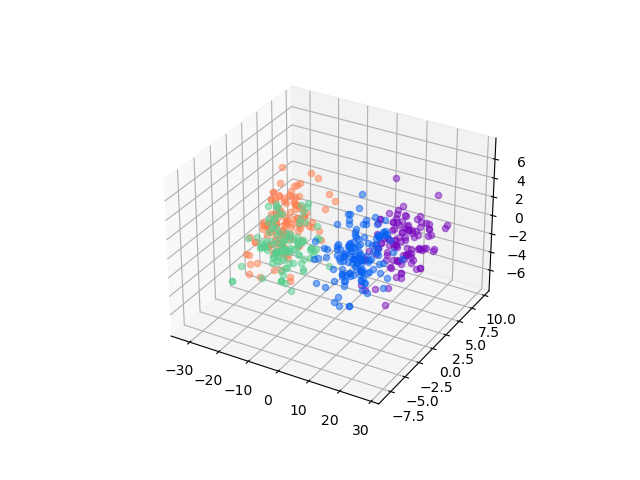

In [230]:
sparse = MP_reorder_projection.iloc[np.random.choice(len(MP_reorder_projection),int(len(MP_reorder_projection)*0.2)),:]
plotProjection(sparse,'MP','Loc')

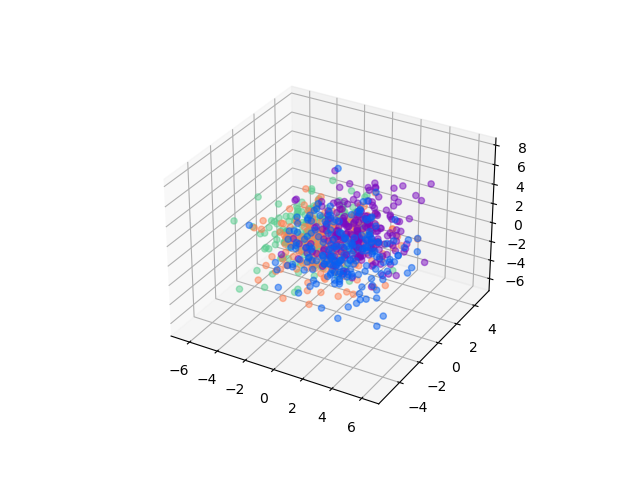

In [538]:
sparse = PRL_data_projection.iloc[np.random.choice(len(PRL_data_projection),int(len(PRL_data_projection)*0.02)),:]
plotProjection(sparse,'PRL','Col')

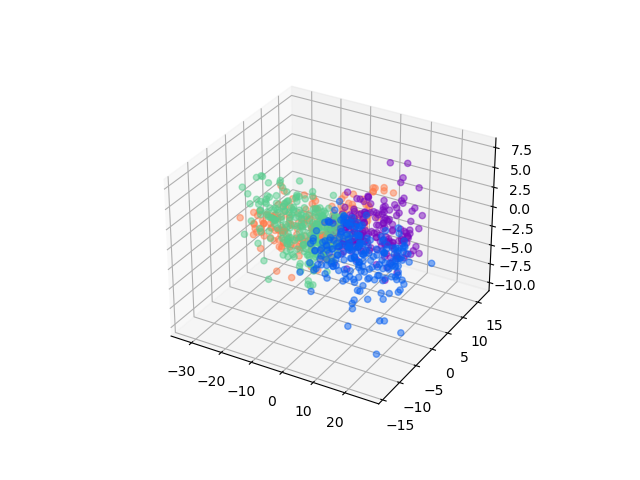

In [539]:
sparse = data_projection.iloc[np.random.choice(len(data_projection),int(len(data_projection)*0.02)),:]
plotProjection(sparse,'MP','Loc')

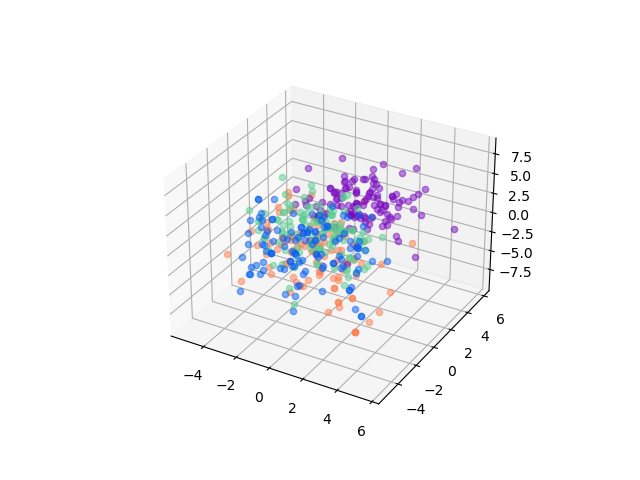

In [231]:
reorder_accuracy, reorder_projection = reorder_date(PRL[(PRL.area==0) & (PRL.Volatility==1)], PRL_regressors, 'Col')
sparse = reorder_projection.iloc[np.random.choice(len(reorder_projection),int(len(reorder_projection)*0.2)),:]
plotProjection(sparse,'PRL','Col')

In [521]:
data_accuracy, data_projection = decode(MP[MP.area==0], 'Loc', np.arange(18), num_iter=2)

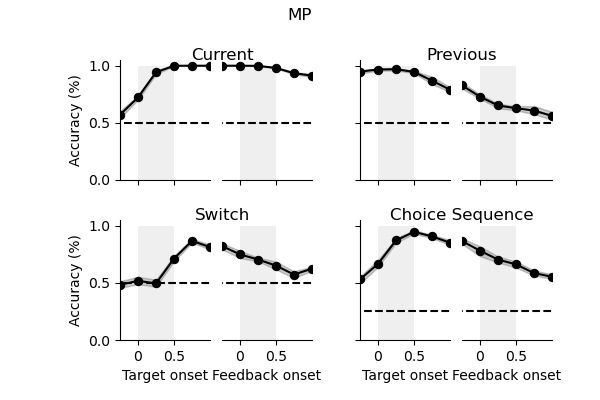

In [526]:
plot_dataacc(data_accuracy,'MP')

In [522]:
PRL_data_accuracy, PRL_data_projection = decode(PRL[(PRL.area==0) & (PRL.Volatility==1)], 'Col', np.arange(18), num_iter=2)

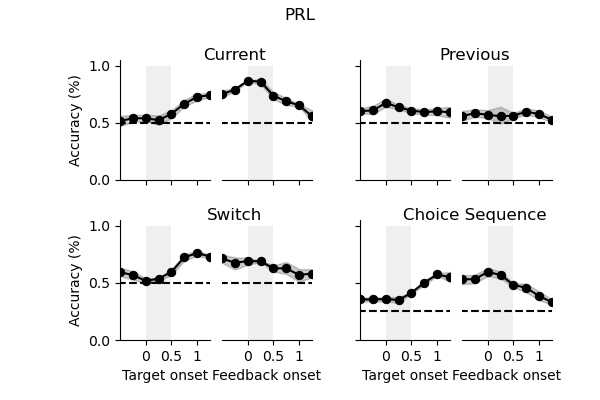

In [525]:
plot_dataacc(PRL_data_accuracy,'PRL')

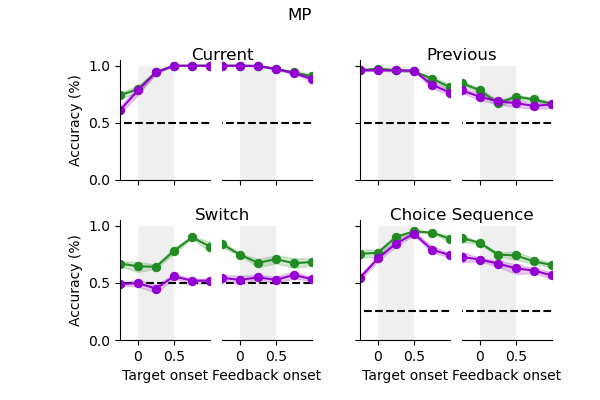

In [530]:
# MP_original_accuracy, MP_original_projection, MP_removal_accuracy, MP_removal_projection = original_removal_cmp(MP[MP.area==0], MP_regressors, 'Loc')
plot_original_removal(MP_original_accuracy,MP_removal_accuracy,'MP')

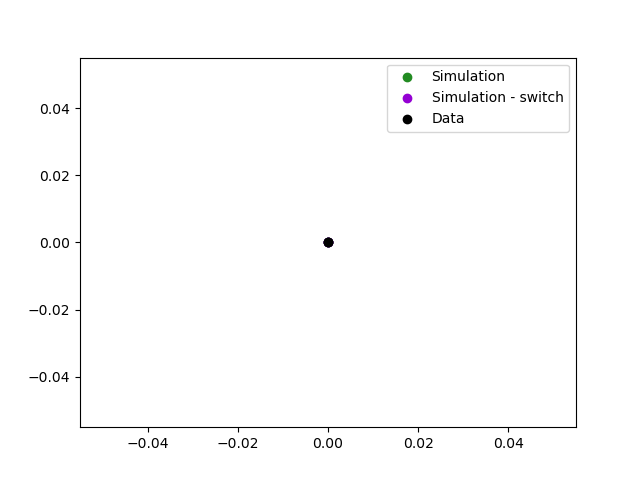

In [533]:
plt.close('all')
plt.scatter([0,0],[0,0],color='forestgreen',label='Simulation')
plt.scatter([0,0],[0,0],color='darkviolet',label='Simulation - switch')
plt.scatter([0,0],[0,0],color='k',label='Data')
plt.legend()

In [529]:
def plot_original_removal(original_accuracy,removal_accuracy,task):

    plt.close('all')
#     fig = plt.figure(figsize=(6,4),facecolor=(1, 1, 1))
#     gs = gridspec.GridSpec(2,4)
    fig, axs = plt.subplots(2, 4, figsize=(6,4),facecolor=(1, 1, 1))
    variables = ['Current','Previous','Switch','Choice Sequence']

    if task == 'PRL':
        ticklabels = ['0', '0.5', '1']
        ticks=[[2,4,6],[11,13,15]]
        tlim=[[-1,8],[8,17]]
    else:
        ticklabels = ['0', '0.5']
        ticks=[[2,4],[11,13]]
        tlim=[[0,7],[9,16]]
        
    ticksize=10
    titlesize=12

    for var in range(4):
        
        for ax_ind in range(2):
            
#             ax=plt.subplot(gs[int(np.floor(var/2)),ax_ind+2*(var%2)])
            ax=axs[int(np.floor(var/2)),ax_ind+2*(var%2)]
            sns.lineplot(original_accuracy[(original_accuracy.Time>tlim[ax_ind][0]) & (original_accuracy.Time<tlim[ax_ind][1])],
                         x='Time',y=variables[var],color='forestgreen',ax=ax,zorder=2,marker='o',markeredgecolor=None)
            sns.lineplot(removal_accuracy[(removal_accuracy.Time>tlim[ax_ind][0]) & (removal_accuracy.Time<tlim[ax_ind][1])],
                         x='Time',y=variables[var],color='darkviolet',ax=ax,zorder=2,marker='o',markeredgecolor=None)

            ax.set_xticks(ticks[ax_ind])
            ax.set_ylim(0,1.05)
            ax.set_xlim(tlim[ax_ind][0]+1,tlim[ax_ind][1]-1)
                
                
            if ax_ind == 0:

                ax.fill_between([2,4],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['right', 'top']].set_visible(False)
                ax.set_xlabel('Target onset',fontsize=ticksize)
                    
                if var%2==0:
                    ax.set_ylabel('Accuracy (%)')
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels('')
                
            else:
                ax.fill_between([11,13],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['left', 'right', 'top']].set_visible(False)
                ax.set_xlabel('Feedback onset',fontsize=ticksize)
                ax.set_ylabel('')
                ax.set_yticks([])
                
            if var == 3:
                ax.plot(np.array(tlim[ax_ind]),[0.25,0.25],'k--',zorder=1)
            else:
                ax.plot(np.array(tlim[ax_ind]),[0.5,0.5],'k--',zorder=1)     
                
            if var < 2:
                ax.set_xticklabels('')
                ax.set_xlabel('')
            else:
                ax.set_xticklabels(ticklabels,fontsize=ticksize)
                    

                
            ax.set_position([0.2+0.4*(var%2)+0.17*ax_ind,0.55-0.4*np.floor(var/2),0.15,0.3])

                    
        ax.text(10,1.05,variables[var],fontsize=titlesize,ha='center')


    plt.suptitle(task,fontsize=titlesize)


In [523]:
def plot_dataacc(accuracy,task):

    plt.close('all')
#     fig = plt.figure(figsize=(6,4),facecolor=(1, 1, 1))
#     gs = gridspec.GridSpec(2,4)
    fig, axs = plt.subplots(2, 4, figsize=(6,4),facecolor=(1, 1, 1))
    variables = ['Current','Previous','Switch','Choice Sequence']

    if task == 'PRL':
        ticklabels = ['0', '0.5', '1']
        ticks=[[2,4,6],[11,13,15]]
        tlim=[[-1,8],[8,17]]
    else:
        ticklabels = ['0', '0.5']
        ticks=[[2,4],[11,13]]
        tlim=[[0,7],[9,16]]
        
    ticksize=10
    titlesize=12

    for var in range(4):
        
        for ax_ind in range(2):
            
#             ax=plt.subplot(gs[int(np.floor(var/2)),ax_ind+2*(var%2)])
            ax=axs[int(np.floor(var/2)),ax_ind+2*(var%2)]
            sns.lineplot(accuracy[(accuracy.Time>tlim[ax_ind][0]) & (accuracy.Time<tlim[ax_ind][1])],
                         x='Time',y=variables[var],color='k',ax=ax,zorder=2,marker='o',markeredgecolor=None)

            ax.set_xticks(ticks[ax_ind])
            ax.set_ylim(0,1.05)
            ax.set_xlim(tlim[ax_ind][0]+1,tlim[ax_ind][1]-1)
                
                
            if ax_ind == 0:

                ax.fill_between([2,4],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['right', 'top']].set_visible(False)
                ax.set_xlabel('Target onset',fontsize=ticksize)
                    
                if var%2==0:
                    ax.set_ylabel('Accuracy (%)')
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels('')
                
            else:
                ax.fill_between([11,13],[1,1],color=[0.6,0.6,0.6],alpha=0.15,edgecolor=None)
                ax.spines[['left', 'right', 'top']].set_visible(False)
                ax.set_xlabel('Feedback onset',fontsize=ticksize)
                ax.set_ylabel('')
                ax.set_yticks([])
                
            if var == 3:
                ax.plot(np.array(tlim[ax_ind]),[0.25,0.25],'k--',zorder=1)
            else:
                ax.plot(np.array(tlim[ax_ind]),[0.5,0.5],'k--',zorder=1)     
                
            if var < 2:
                ax.set_xticklabels('')
                ax.set_xlabel('')
            else:
                ax.set_xticklabels(ticklabels,fontsize=ticksize)
                    

                
            ax.set_position([0.2+0.4*(var%2)+0.17*ax_ind,0.55-0.4*np.floor(var/2),0.15,0.3])

                    
        ax.text(10,1.05,variables[var],fontsize=titlesize,ha='center')


    plt.suptitle(task,fontsize=titlesize)


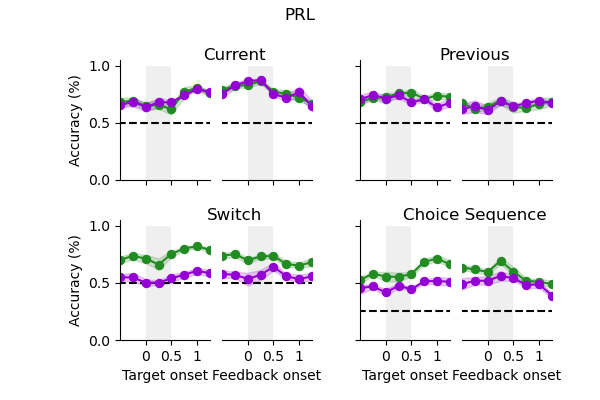

In [520]:
# original_accuracy, original_projection, removal_accuracy, removal_projection = original_removal_cmp(PRL[(PRL.area==0) & (PRL.Volatility==1)], PRL_regressors, 'Col')
plot_original_removal(original_accuracy,removal_accuracy,'PRL')

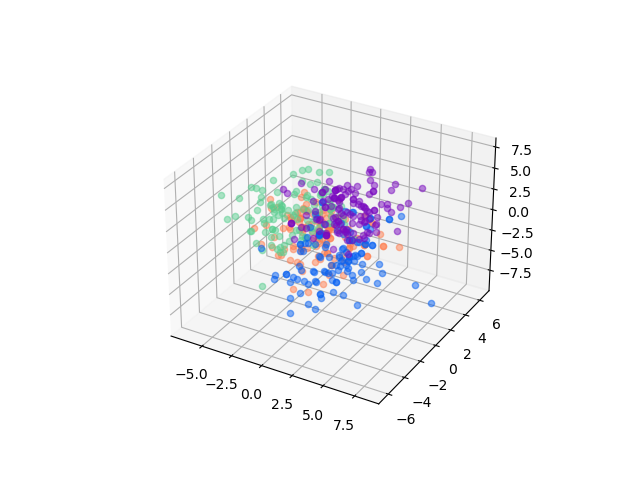

In [211]:
time_projection = original_projection[original_projection.Time==6]
sparse = time_projection.iloc[np.random.choice(len(time_projection),int(len(time_projection)*0.2)),:]
plotProjection(sparse,'PRL','Col')

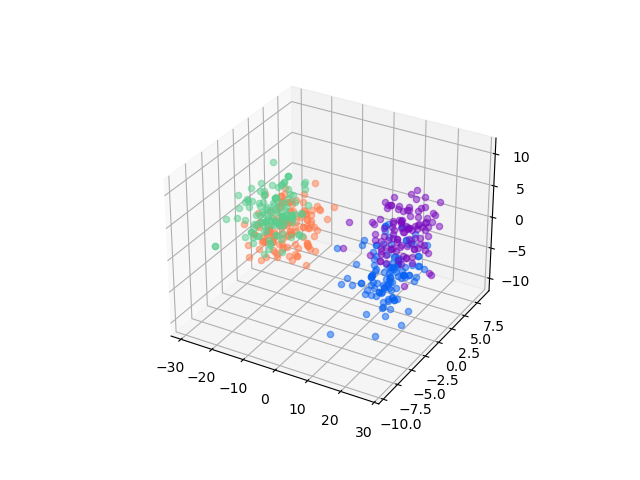

In [208]:
time_projection = MP_original_projection[MP_original_projection.Time==6]
sparse = time_projection.iloc[np.random.choice(len(time_projection),int(len(time_projection)*0.2)),:]
plotProjection(sparse,'MP','Loc')

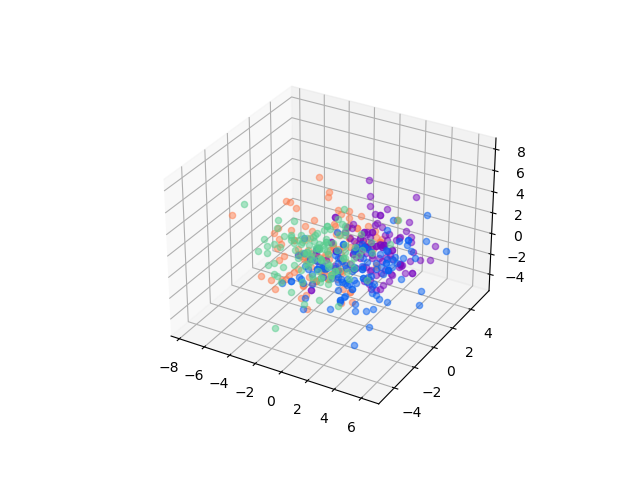

In [204]:
time_projection = removal_projection[removal_projection.Time==6]
sparse = time_projection.iloc[np.random.choice(len(time_projection),int(len(time_projection)*0.2)),:]
plotProjection(sparse,'PRL','Col')

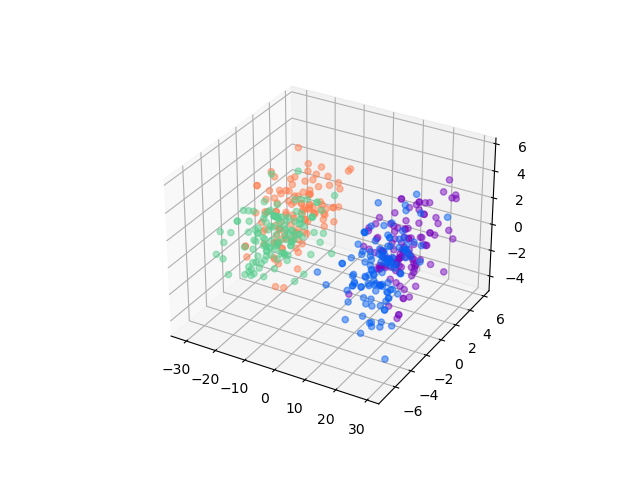

In [248]:
time_projection = MP_removal_projection[MP_removal_projection.Time==6]
sparse = time_projection.iloc[np.random.choice(len(time_projection),int(len(time_projection)*0.2)),:]
plotProjection(sparse,'MP','Loc')

In [246]:
def plotProjection(Projection,task,var):
    
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')   
    colors = ['#59ce8f', '#ff7f50', '#0761f2', '#7a0bc0']

    for var1 in [-1,1]:
        for var2 in [-1,1]:
            
            c = int(var1+var2/2+1.5)
            
            conditioned = Projection[(Projection.Current==var1) & (Projection.Previous==var2)]
            conditioned_mean = conditioned.mean()

            ax.scatter3D(conditioned.CurrentProjection.values, conditioned.PreviousProjection.values,
                         conditioned.SwitchProjection.values, color=colors[c], marker='o', depthshade=True, s=20, alpha=0.5)


    plt.show()
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    
    if var=='Col':
        
        plt.legend(['G->G','R->G','G->R','R->R'])
        
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        ax.set_zlim(-5,5)

        ax.set_xticks([-2.5,0,2.5])
        ax.set_yticks([-2.5,0,2.5])
        ax.set_zticks([-2.5,0,2.5])
        
    else:
        plt.legend(['L->L','R->L','L->R','R->R'])
        
        ax.set_xlim(-30,30)
        ax.set_ylim(-10,10)
        ax.set_zlim(-10,10)

        ax.set_xticks([-15,0,15])
        ax.set_yticks([-5,0,5])
        ax.set_zticks([-5,0,5])

    ax.set_xlabel(var+'(t)')
    ax.set_ylabel(var+'(t-1)')
    ax.set_zlabel('Switch')
    ax.view_init(azim=100,elev=-170)
#     plt.savefig(task+' '+var+' projection on the encoding axis')

#     ax.view_init(azim=0,elev=0)
#     plt.savefig(task+' '+var+' projection on the encoding axis 1')

#     ax.view_init(azim=90,elev=0)
#     plt.savefig(task+' '+var+' projection on the encoding axis 2')

#     ax.view_init(azim=90,elev=90)
#     plt.savefig(task+' '+var+' projection on the encoding axis 3')

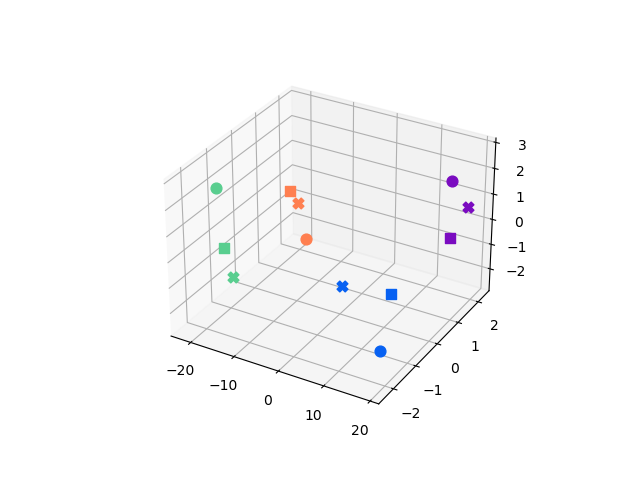

In [296]:
plotMeanProjection(MP_original_projection[MP_original_projection.Time==6],
                   MP_removal_projection[MP_removal_projection.Time==6],
                   MP_reorder_projection,'MP','Loc')

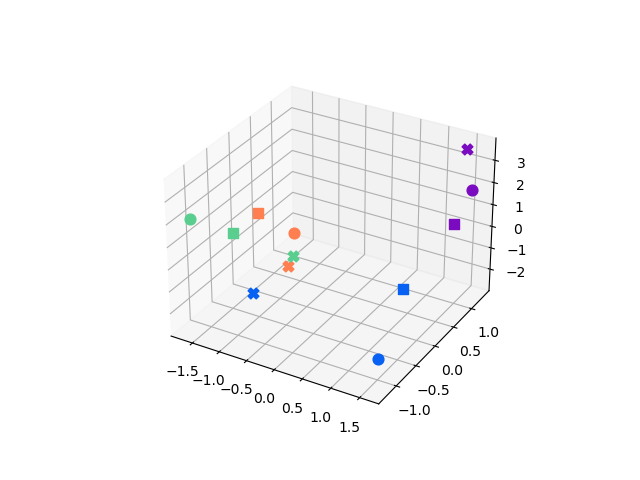

In [295]:
plotMeanProjection(original_projection[original_projection.Time==6],
                   removal_projection[removal_projection.Time==6],
                   reorder_projection,'PRL','Col')

In [291]:
def plotMeanProjection(Original,Removal,Reorder,task,var):

    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d') 
    colors = ['#59ce8f', '#ff7f50', '#0761f2', '#7a0bc0']

    for var1 in [-1,1]:
        for var2 in [-1,1]:
            
            c = int(var1+var2/2+1.5)
            
            conditioned = Original[(Original.Current==var1) & (Original.Previous==var2)].mean()

            ax.scatter3D(conditioned.CurrentProjection, conditioned.PreviousProjection,
                         conditioned.SwitchProjection, color=colors[c], marker='o', depthshade=False, s=60)

            
            conditioned = Removal[(Removal.Current==var1) & (Removal.Previous==var2)].mean()

            ax.scatter3D(conditioned.CurrentProjection, conditioned.PreviousProjection,
                         conditioned.SwitchProjection, color=colors[c], marker='s', depthshade=False, s=60)
  
            conditioned = Reorder[(Reorder.Current==var1) & (Reorder.Previous==var2)].mean()

            ax.scatter3D(conditioned.CurrentProjection, conditioned.PreviousProjection,
                         conditioned.SwitchProjection, color=colors[c], marker='X', depthshade=False, s=60)
        
    plt.show()
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    
    handles=[[] for x in range(7)]
    for c in range(4):
        handles[c]=ax.scatter3D(100,100,100, color=colors[c], marker='o', depthshade=False, s=60)
    handles[4]=ax.scatter3D(100,100,100, color='k', marker='o', depthshade=False, s=60)
    handles[5]=ax.scatter3D(100,100,100, color='k', marker='s', depthshade=False, s=60)
    handles[6]=ax.scatter3D(100,100,100, color='k', marker='X', depthshade=False, s=60)
    
    if var=='Col':
        
        plt.legend(handles,['G->G','R->G','G->R','R->R','Original','Removal','Correlated'],ncol=2,frameon=False)
        
        ax.set_xlim(-3,3)
        ax.set_ylim(-3,3)
        ax.set_zlim(-3,3)

        ax.set_xticks([-2.5,0,2.5])
        ax.set_yticks([-2.5,0,2.5])
        ax.set_zticks([-2.5,0,2.5])
        
    else:      
        
        plt.legend(handles,['L->L','R->L','L->R','R->R','Original','Removal','Correlated'],ncol=2,frameon=False)
        
        ax.set_xlim(-20,20)
        ax.set_ylim(-10,10)
        ax.set_zlim(-5,5)

        ax.set_xticks([-15,0,15])
        ax.set_yticks([-5,0,5])
        ax.set_zticks([-5,0,5])

    ax.set_xlabel(var+'(t)')
    ax.set_ylabel(var+'(t-1)')
    ax.set_zlabel('Switch')
    ax.view_init(azim=100,elev=-170)
#     plt.savefig(task+' '+var+' projection on the encoding axis')

#     ax.view_init(azim=0,elev=0)
#     plt.savefig(task+' '+var+' projection on the encoding axis 1')

#     ax.view_init(azim=90,elev=0)
#     plt.savefig(task+' '+var+' projection on the encoding axis 2')

#     ax.view_init(azim=90,elev=90)
#     plt.savefig(task+' '+var+' projection on the encoding axis 3')